In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import scipy

warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
from os import listdir
maf_dir = '/Users/maayanbaron/Documents/Data/maf_files/per_cohort/'
maf_files_list = listdir(maf_dir)

cohort_names = []
for name in maf_files_list:
    cohort_names.append(name.split('.')[0].split('_')[0])
    
des_genes = ['DSP','DSC1','DSC2','DSC3','DSG1','DSG2',
               'DSG3','DSG4','PKP1','PKP2', 'PKP3','PKP4','JUP']
#des_genes = ['DSG1','DSG3','DSC3','PKP3','PKP2']
df_freq = pd.DataFrame(index=cohort_names,columns=['num_of_samples_with_des_mut','num_of_samples','SNP','DEL','INS'])
for file in maf_files_list:
    f = pd.read_csv(maf_dir+file,sep='\t')
    idx = file.split('.')[0].split('_')[0]
    f_des = f[f['Hugo_Symbol'].isin(des_genes)]
    f_des = f_des[f_des['Variant_Type']!='Silent']
    df_freq.loc[idx,'num_of_samples_with_des_mut'] = len(f_des['Tumor_Sample_Barcode'].unique())
    df_freq.loc[idx,2:5]  = f_des.groupby(['Tumor_Sample_Barcode','Variant_Type']).count().index.get_level_values(1).value_counts()
df_freq['num_of_samples']= pd.read_csv('/Users/maayanbaron/Documents/Data/maf_files/num_of_patients.txt',sep='\t',index_col=0,header=None)
df_freq['frequency'] = 100*df_freq['num_of_samples_with_des_mut']/df_freq['num_of_samples']
df_freq.head()

,num_of_samples_with_des_mut,num_of_samples,SNP,DEL,INS,frequency
kirc,29,538,26,2,1,5.39033
uvm,3,80,2,1,NaN,3.75
brca,100,1108,95,7,NaN,9.02527
chol,3,51,3,NaN,NaN,5.88235
blca,130,413,129,1,NaN,31.477


In [29]:
df_freq.loc[df_freq.index.sort_values()]

,num_of_samples_with_des_mut,num_of_samples,SNP,DEL,INS,frequency
acc,14,92,14,NaN,NaN,15.2174
blca,130,413,129,1,NaN,31.477
brca,100,1108,95,7,NaN,9.02527
cesc,62,310,58,3,2,20
chol,3,51,3,NaN,NaN,5.88235
coadread,121,640,120,11,5,18.9062
dlbc,11,48,11,NaN,NaN,22.9167
esca,25,186,22,2,1,13.4409
gbm,75,619,73,2,1,12.1163
hnsc,85,530,81,5,2,16.0377


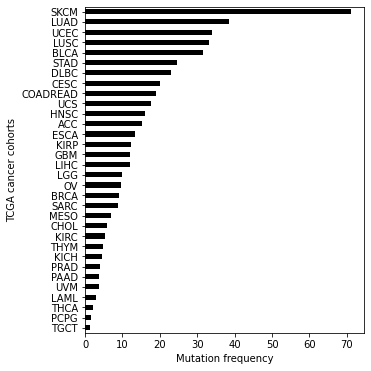

In [7]:
data = df_freq
data = data.sort_values(by='frequency',ascending=True)
ax = data['frequency'].plot(kind='barh',figsize=(5,6),color='k');
cohort_names_upper = [x.upper() for x in data.index.to_list()]
ax.set_yticklabels(cohort_names_upper);
plt.xlabel('Mutation frequency');
plt.ylabel('TCGA cancer cohorts');
#plt.savefig('/cellar/users/m2baron/work2020/MEL_desmosomes/figures/des_freq_across_cohorts.pdf',dpi=600,bbox_inches='tight')

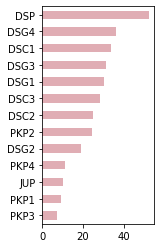

In [8]:
#melanoma des distrbution    
des_genes = ['DSP','DSC1','DSC2','DSC3','DSG1','DSG2',
               'DSG3','DSG4','PKP1','PKP2', 'PKP3','PKP4','JUP']
f = pd.read_csv(maf_dir+'skcm_tcga.maf',sep='\t')
idx = file.split('.')[0].split('_')[0]
f_des = f[f['Hugo_Symbol'].isin(des_genes)]
f_des = f_des[f_des['Variant_Type']!='Silent']
df_freq_des = f_des['Hugo_Symbol'].value_counts()/df_freq.loc['skcm','num_of_samples']

data = df_freq_des*100
data = data.sort_values(ascending=True)
ax = data.plot(kind='barh',figsize=(2,4),color="#e0adb4");
#plt.savefig('/cellar/users/m2baron/work2020/MEL_desmosomes/figures/des_dist_skcm.pdf',dpi=600,bbox_inches='tight')

In [25]:
#calculate p-value for each cohort based on MutSig output
#1. import MutSig expected mutation number
path = '/Users/maayanbaron/Documents/Data/desmosomes/MutSigCV/mutsigcv1.4_pancanceratlas_expect.csv'
df_expected = pd.read_csv(path,index_col=0,sep='\t')
#fix columns name to match
new_col = []
for col in df_expected.columns:
    new_col.append(col.split('_')[0])#+'_tcga')
df_expected.columns = new_col
#2. import observed TCGA mutation number
path = '/Users/maayanbaron/Documents/Data/desmosomes/MutSigCV/mutsigcv1.4_pancanceratlas_observe.csv'
df_observed = pd.read_csv(path,index_col=0,sep='\t')
#fix columns name to match
new_col = []
for col in df_observed.columns:
    new_col.append(col.split('_')[0])#+'_tcga')
df_observed.columns = new_col
#3. calculate the diffrence and sort genes
df_diff = df_observed-df_expected

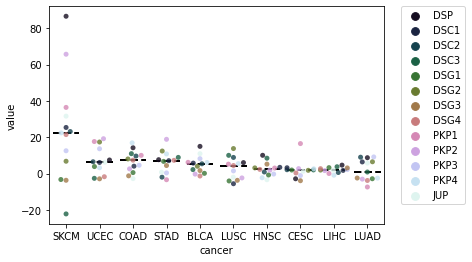

In [26]:
df = pd.melt(df_diff.loc[des_genes],ignore_index=False,var_name='cancer')
df['value'] = -df['value']
df = df[df['cancer'] != 'pancancer']
df['cancer'] = df['cancer'].str.upper()

#filter for top 10 cancers
top10 = df.groupby(by='cancer').mean().sort_values(by='value',ascending=False).index[0:10]
df_top10 = df[df['cancer'].isin(top10)]

order = df_top10.groupby(by='cancer').mean().sort_values(by='value',ascending=False).index.to_list()
y = df_top10['value']
x = df_top10['cancer']



p = sns.swarmplot(y=y,x=x,hue=df_top10.index,order=order,alpha=0.8,palette='cubehelix');

df_mean = df_top10.groupby('cancer').median()
df_mean = df_mean.loc[order]
_ = [p.hlines(y, i-.4, i+.4, zorder=2,colors='k',linestyles='dashed',linewidths=2) for i, y in df_mean.reset_index()['value'].items()]

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
#plt.savefig('figures/des_freq__mutsig_across_cohorts.pdf',dpi=600,bbox_inches='tight')

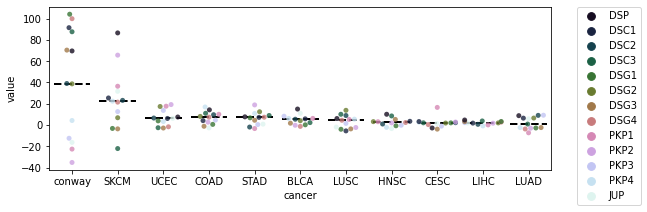

In [46]:
X = pd.melt(df_conway_diff_des)
X.index = df_conway_diff_des.index
X.columns=['cancer','value']
X2 = pd.concat([X,df_top10],axis=0)
y = 'value'
x = 'cancer'
order = X2.groupby(by='cancer').mean().sort_values(by='value',ascending=False).index.to_list()

a4_dims = (9,3)
fig, ax = plt.subplots(figsize=a4_dims)

p = sns.swarmplot(data=X2,y=y,x=x,hue=X2.index,order=order,alpha=0.8,palette='cubehelix');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
df_mean = X2.groupby('cancer').median()
df_mean = df_mean.loc[order]
_ = [p.hlines(y, i-.4, i+.4, zorder=2,colors='k',linestyles='dashed',linewidths=2) for i, y in df_mean.reset_index()['value'].items()]
plt.savefig('figures/des_freq__mutsig_across_cohorts_withconway.pdf',dpi=600,bbox_inches='tight')

In [8]:
#import df_pval
df_pval = pd.read_csv("bootstrap_pvals_100k.tsv",sep='\t',index_col=0)
df_pval[df_pval['pval']/len(df_pval['pval'])<0.0000001]

,pval
blca,0.0
cesc,0.0
coad,0.0
esca,0.0
hnsc,0.0
lihc,0.0
luad,0.0
lusc,0.0
prad,0.0
skcm,0.0


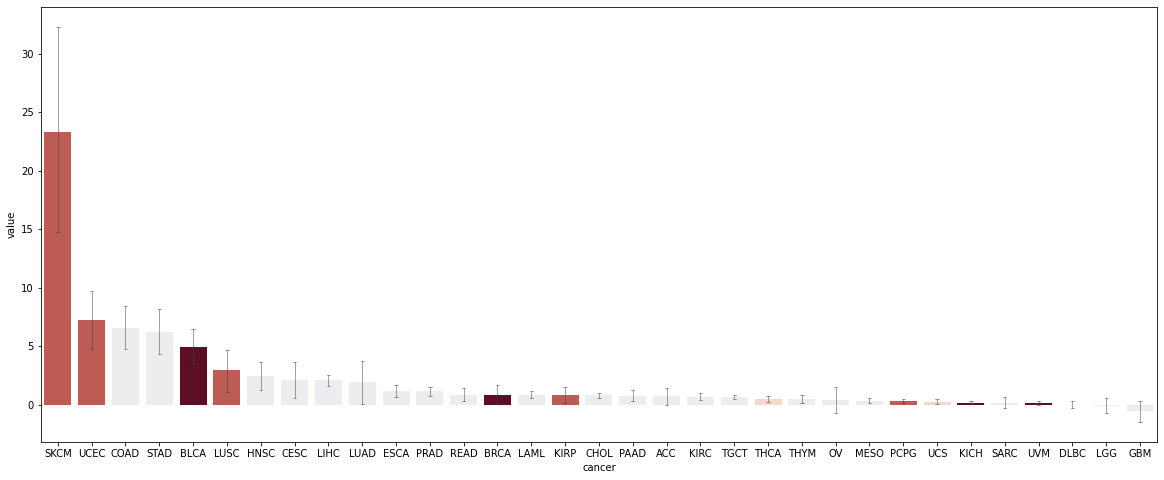

In [100]:
df = pd.melt(df_diff.loc[des_genes],ignore_index=False,var_name='cancer')
df['value'] = -df['value']
df = df[df['cancer'] != 'pancancer']
df['cancer'] = df['cancer'].str.upper()

df_colors = pd.DataFrame(data = '#EAEDEE',index=df_pval.index,columns=['Color'])
df_colors
df_colors.loc[df_pval[df_pval['pval']<0.01].index] = '#f9d7c4'
df_colors.loc[df_pval[df_pval['pval']<0.005].index] = '#cd4d44'
df_colors.loc[df_pval[df_pval['pval']<0.001].index] = '#69011f'
#df_colors.loc['skcm'] = '#69011f'
df_colors.index = data.index.str.upper()


order = df.groupby(by='cancer').mean().sort_values(by='value',ascending=False).index.to_list()
y = df['value']
x = df['cancer']

a4_dims = (20,8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(y=y,x=x,palette=df_colors['Color'],ci=75,errwidth=0.5,capsize=0.1,order=order);
plt.savefig('figures/des_freq__mutsig_across_cohorts.pdf',dpi=600,bbox_inches='tight')

In [ ]:
#old stuff that I don't need
data = pd.concat([df_freq,df_colors],axis=1)
data = data.sort_values(by='frequency',ascending=True)
data.iloc[:,2] = df_freq['SNP']/df_freq['num_of_samples']
data.iloc[:,3] = df_freq['DEL']/df_freq['num_of_samples']
data.iloc[:,4] = df_freq['INS']/df_freq['num_of_samples']
data.iloc[:,2:5].plot(kind='barh',stacked=True,figsize=(3,6));
plt.xlabel('Desmosome alteration frequency');
plt.ylabel('Cancer TCGA cohorts');
#plt.savefig('figures/des_freq_across_cohorts_SNP_DEL_INS.pdf',dpi=600,bbox_inches='tight')

In [ ]:
#creating a color pallette for TCGA cohorts
df_colors = pd.DataFrame(data = '#000000',index=df_freq.index,columns=['Color'])
colors = (sns.color_palette("twilight",n_colors=8)).as_hex()
df_colors.loc[['acc','gbm','lgg']] = colors[0] #brain
df_colors.loc[['blca','cesc','ov','ucec','ucs']]  = colors[1]#gynecolgy
df_colors.loc[['hnsc','sarc']] = colors[2] #bones and head
df_colors.loc[['brca']] = colors[3] #breast
df_colors.loc[['esca','kich','kirc','kirp','pcpg','stad','coadread']] = colors[4] #gastro
df_colors.loc[['laml','dlbc']] = colors[5] #blood
df_colors.loc[['luad','lusc','meso']] = colors[6] #lung
df_colors.loc[['skcm','uvm']] = colors[7] #skin
df_colors.loc[['lihc','paad','chol','prad','tgct']] = colors[4]# liver, pancreas prostate and testis
df_colors.loc[['thca','thym']] = colors[4] #endo


In [ ]:
import xlmhg
from hypergeometric_util import *

df_pval = pd.DataFrame(index=df_diff.columns,columns=['escore','fold_enrichment','cutoff','pval'])
df_folds = pd.DataFrame(columns=df_diff.columns)
df_idx = pd.DataFrame(columns=df_diff.columns)
df_idx_names = pd.DataFrame(columns=df_diff.columns)

for coh in df_diff.columns:
    v = pd.DataFrame(data=0,index=df_diff[coh].sort_values(ascending=False).index,columns=['Des_genes'])
    v.loc[des_genes,'Des_genes']=1
    #doing the test 
    N = v.shape[0]
    indicies = np.uint16(np.nonzero(v.values)[0])
    des_order = v.index[indicies]
    df_idx[coh] = indicies
    df_idx_names[coh] = des_order
    result = xlmhg.get_xlmhg_test_result(N,indicies)
    df_pval.loc[coh,'escore'] = result.escore
    df_pval.loc[coh,'fold_enrichment'] = result.fold_enrichment
    df_pval.loc[coh,'cutoff'] = result.cutoff
    df_pval.loc[coh,'pval'] = result.pval
    pvals, folds = get_hypergeometric_stats(N,indicies)
    df_folds[coh] = folds

In [ ]:
data = np.log2(df_folds[df_pval.sort_values(by='escore',ascending=False).index])

fig = plt.gcf()
fig.set_size_inches(3,10)

coh_to_plot = ['skcm','dlbc','gbm','lgg','luad','ov']
i = 1
for coh in coh_to_plot:
    #plot enrichment
    plt.subplot(len(coh_to_plot),1,i)
    ax = data[coh].plot(c='k'); plt.box('off')
    #add des genes as scatter
    x = df_idx[coh]
    y = data.iloc[df_idx[coh].values][coh]
    plt.scatter(x=x,y=y,c='#cd4d44')
    #add cutoff line
    xc = df_pval.loc[coh,'cutoff']
    plt.axvline(x=xc, color='k', linestyle='--')
    i = i+1
    plt.title(coh);
    plt.axis('off');
fig.tight_layout() 
#plt.savefig('figures/waterfall_plots.pdf',dpi=600,bbox_inches='tight')

In [ ]:
data = pd.concat([df_pval['escore'],df_colors],axis=1)
#data['fold_enrichment'] = np.log2(data['fold_enrichment'].astype('float'))
data['escore'] = np.log2(data['escore'].astype('float'))
data = data.drop('pancancer')

data = data.sort_values(by='escore',ascending=True)

ax = data['escore'].plot(kind='barh',figsize=(2.5,6),color=data['Color']);
cohort_names_upper = [x.upper() for x in data.index.to_list()]
ax.set_yticklabels(cohort_names_upper)
plt.axvline(1, color = 'k', linestyle=':');
plt.ylabel('enrichment score [log2]');
plt.xlabel('Cancer TCGA cohorts');
plt.savefig('/cellar/users/m2baron/work2020/MEL_desmosomes/figures/des_escore_across_cohorts.pdf',dpi=600,bbox_inches='tight')